In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import cvlib as cv

In [17]:
directory=r'C:\Users\kumar\Downloads\gender\dataset1\train'
categories=['man','woman']
data=[]

for folder in categories:
    folder_path=os.path.join(directory,folder)
    labels=categories.index(folder)
    for img in os.listdir(folder_path):
        img_path=os.path.join(folder_path,img)
        img=cv2.imread(img_path)
        img=cv2.resize(img,(100,100))
        data.append([img,labels])

In [23]:
feature,label=[],[]
random.shuffle(data)
for x,y in data:
    feature.append(x)
    label.append(y)

In [24]:
feature=np.array(feature,dtype='float')/255.0
label=np.array(label)

In [25]:
epochs=100
lr=1e-3
batch_size=64
img_dims=(100,100,3)

In [27]:
x_train,x_test,y_train,y_test=train_test_split(feature,label,test_size=0.2,random_state=42)
y_train=to_categorical(y_train,num_classes=2)
y_test=to_categorical(y_test,num_classes=2)

In [28]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [29]:
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": 
        inputShape = (depth, height, width)
        chanDim = 1


    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model


In [31]:
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],classes=2)
optimizer = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size),validation_data=(x_test,y_test),
                        steps_per_epoch=len(x_train) // batch_size,
                        epochs=epochs, verbose=1)



Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 20 steps, validate on 320 samples
Epoch 1/100
20/20 [==============================] - 47s 2s/step - loss: 0.8336 - accuracy: 0.6793 - val_loss: 0.7284 - val_accuracy: 0.5375
Epoch 2/100
20/20 [==============================] - 37s 2s/step - loss: 0.5342 - accuracy: 0.7723 - val_loss: 0.9249 - val_accuracy: 0.5250
Epoch 3/100
20/20 [==============================] - 38s 2s/step - loss: 0.4227 - accuracy: 0.8230 - val_loss: 1.0871 - val_accuracy: 0.5250
Epoch 4/100
20/20 [==============================] - 37s 2s/step - loss: 0.4071 - accuracy: 0.8336 - val_loss: 1.8330 - val_accuracy: 0.5250
Epoch 5/100
20/20 [==============================] - 36s 2s/step - loss: 0.3655 - accuracy: 0.8508 - val_loss: 1.7558 - val_accuracy: 0.5250
Epoch 6/100
20/20 [==============================] - 38s 2s/step - loss: 0.3188 - accuracy: 0.8781 - val_loss: 0.7862 - val_accuracy: 0.5250
Epoch 7/1

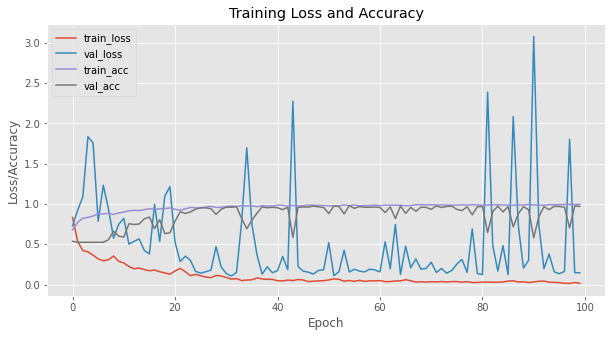

In [35]:
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,epochs), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,epochs), H.history["val_accuracy"], label="val_accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()


In [40]:
vd=cv2.VideoCapture(0)

while vd.isOpened():
    ret,frame=vd.read()
    face,confidence=cv.detect_face(frame)
    
    for idx,f in enumerate(face):
        start_x,start_y,end_x,end_y=f[0],f[1],f[2],f[3]
        cv2.rectangle(frame,(start_x,start_y),(end_x,end_y),(0,255,0),2)
        face_crop=np.copy(frame[start_y:end_y,start_x:end_x])
        face_crop = cv2.resize(face_crop, (100,100))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)
        
        conf=model.predict(face_crop)[0]
        idx=np.argmax(conf)
        label=categories[idx]
        
        label = "{}: {:.2f}%".format(label, conf[idx] * 100)
        
        y=start_y-10 if start_y-10>10 else start_y +10
        cv2.putText(frame, label, (start_x, y),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
        
    cv2.imshow('gender detection',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
vd.release()
cv2.destroyAllWindows()
        